# Fiesole

This project aims to demonstrate the feasibility of Vertical-Federated-Learning CNN architectures.


In [1]:
%pip install seaborn
%pip install torch
%pip install torchvision

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [3]:
class QuadrantTransform:
    def __init__(self, quadrant):
        assert quadrant in [
            "tl",
            "tr",
            "bl",
            "br",
        ], "Invalid quadrant. Choose from 'tl', 'tr', 'bl', 'br'"
        self.quadrant = quadrant

    def __call__(self, img):
        # Convert PIL image to tensor
        tensor = transforms.ToTensor()(img)

        # Create a blank (transparent) tensor of the same shape
        blank = torch.zeros_like(tensor)

        if self.quadrant == "tl":
            blank[:, :14, :14] = tensor[:, :14, :14]
        elif self.quadrant == "tr":
            blank[:, :14, 14:] = tensor[:, :14, 14:]
        elif self.quadrant == "bl":
            blank[:, 14:, :14] = tensor[:, 14:, :14]
        elif self.quadrant == "br":
            blank[:, 14:, 14:] = tensor[:, 14:, 14:]

        # Normalize after applying the quadrant transformation
        blank = (blank - 0.5) / 0.5

        return blank

In [4]:
transform_tl = transforms.Compose([QuadrantTransform("tl")])
transform_tr = transforms.Compose([QuadrantTransform("tr")])
transform_bl = transforms.Compose([QuadrantTransform("bl")])
transform_br = transforms.Compose([QuadrantTransform("br")])

transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)

trainset_tl = torchvision.datasets.MNIST(
    root="./control", train=True, download=True, transform=transform_tl
)
trainset_tr = torchvision.datasets.MNIST(
    root="./control", train=True, download=True, transform=transform_tr
)
trainset_bl = torchvision.datasets.MNIST(
    root="./control", train=True, download=True, transform=transform_bl
)
trainset_br = torchvision.datasets.MNIST(
    root="./control", train=True, download=True, transform=transform_br
)

trainloader_tl = torch.utils.data.DataLoader(trainset_tl, batch_size=4)
trainloader_tr = torch.utils.data.DataLoader(trainset_tr, batch_size=4)
trainloader_bl = torch.utils.data.DataLoader(trainset_bl, batch_size=4)
trainloader_br = torch.utils.data.DataLoader(trainset_br, batch_size=4)


testset = torchvision.datasets.MNIST(
    root="./control", train=False, download=True, transform=transform
)
test_loader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

In [5]:
BATCH_SIZE = 32
MNIST_CLASSES = 10

In [6]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc_relu1 = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        x = x.view(-1, 64 * 7 * 7)

        x = self.fc1(x)
        x = self.fc_relu1(x)
        x = self.fc2(x)
        return x

In [7]:
model = CNN()

if torch.cuda.is_available():
    model = model.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

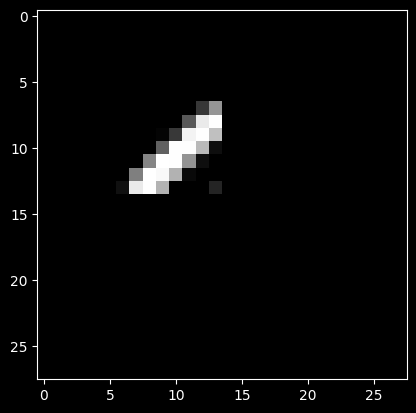

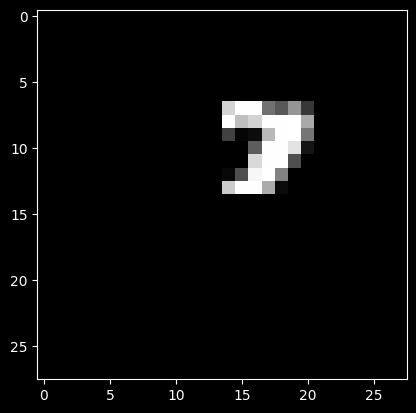

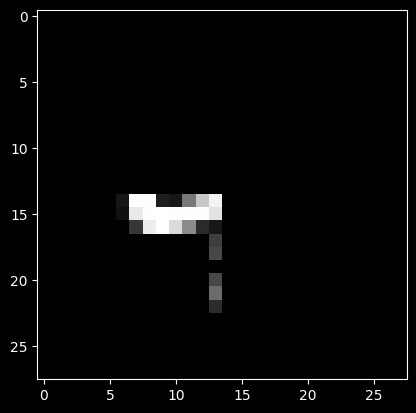

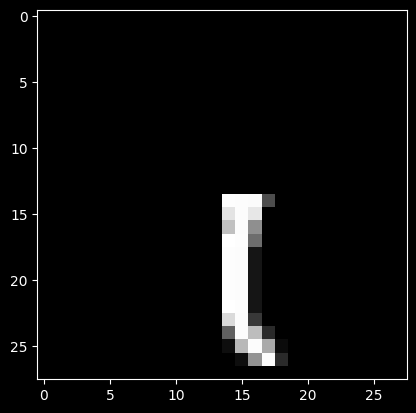

This is a 9


In [8]:
# What does the data look like?
import matplotlib.pyplot as plt


def visualize_mnist_digit(digit):
    if digit.shape != (28, 28):
        digit = digit.reshape(28, 28)
    plt.imshow(digit, cmap="gray")
    plt.show()


data_idx = 4
tl = trainset_tl[data_idx][0]
visualize_mnist_digit(tl)

tr = trainset_tr[data_idx][0]
visualize_mnist_digit(tr)

bl = trainset_bl[data_idx][0]
visualize_mnist_digit(bl)

br = trainset_br[data_idx][0]
visualize_mnist_digit(br)

# Print the labels
print(f"This is a {trainset_tl[data_idx][1]}")

In [9]:
def test_model(model):
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            if torch.cuda.is_available():
                images = images.cuda()
                labels = labels.cuda()
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print(
            "Test Accuracy of the model on the 10000 test images: {} %".format(
                100 * correct / total
            )
        )

In [10]:
# Training loop
def train_model(model, trainloader):
    num_epochs = 1
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(trainloader):
            if torch.cuda.is_available():
                images = images.cuda()
                labels = labels.cuda()
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

In [11]:
def season():
    train_model(model, trainloader_tl)
    test_model(model)
    train_model(model, trainloader_tr)
    test_model(model)
    train_model(model, trainloader_bl)
    test_model(model)
    train_model(model, trainloader_br)
    test_model(model)


for i in range(10):
    season()

In [ ]:
torch.save(model.state_dict(), "fiesole.ckpt")